## Progetto Finale di introduzione alla DataScience
con questo notebook ci poniamo l'obiettivo di
* capire quale sia la categoria di applicazioni avente il massimo rapporto tra numero di recensioni e numero di download (che, da adesso, per brevità, chiameremo nr/nd)

* capire, dentro a questa categoria, se sono più le app a pagamento o quelle free ad avere un nr/nd più alto

* investigare l'esistenza di una eventuale correlazione tra il nr/nd e il rating di una applicazione: se questa metrica cresce, generalmente, il rating aumenterà? Diminuirà? Nessuna delle due? Lo scopriremo

Le ipotesi formulate sono quindi le seguenti:
1. immaginiamo che la categoria di applicazioni avente il massimo rapporto tra numero di recensioni e numero di download siano le app di categoria PRODUCTIVITY (e pensiamo che la categoria SOCIAL sia la seconda) 
2. immaginiamo che, all'interno della categoria trovata, generalmente, le app a pagamento avranno un nr/nd più alto rispetto a quelle free
3. immaginiamo che, al crescere del rapporto nr/nd diminuisca il rating (perché pensiamo che, di solito, se la maggior parte degli utilizzatori lascia una recensione, è per criticare qualcosa piuttosto che per esprimere soddisfazione)


trovare la categoria di app che "eccelle" più delle altre in questa metrica potrebbe aiutare, ad esempio, una software house che vuole sviluppare applicazioni particolarmente innovative o che per qualche motivo hanno bisogno di tanti feedback anche dopo varie release: conoscendo i risultati di questa analisi, saprà su quale categoria puntare, avendo trovato la user-base più "attiva" possibile.

In [ ]:
## importiamo il necessario:
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import numpy as np
import scipy.stats as stats
import sklearn
#importiamo il dataset e visualizziamo prime 5 righe:
playstore = pd.read_csv('googleplaystore.csv')
playstore.head()

In [ ]:
#visualizziamo numero di righe e colonne:
print("Numero Righe, Numero Colonne",playstore.shape)

In [ ]:
#visualizziamo le informazioni del dataset:
playstore.info()

In [ ]:
#visualizziamo eventuali valori nulli:
playstore.isnull().sum()

Come vediamo ci sono ben 1474 righe che hanno valore nullo sulla colonna Rating, potremmo pensare di
* rimuovere tutte queste righe (e quindi ridurre significativamente la dimensione del nostro dataset)
* "completare" i valori nulli usando il valore medio del rating.
Optiamo per la prima opzione, in quanto la seconda potrebbe portare ad una distorsione dei dati per quanto riguarda l'analisi che ci proponiamo di attuare, infatti, se pensiamo di voler cercare una correlazione tra nr/nd e Rating e usiamo il valore medio in tutte le righe che presentano attualmente un valore nullo, avremo dei risultati irrealistici in tutte queste righe,
## esempio:
il rating medio è 2.3, quindi in 1474 entrate avremo il valore 2.3 sulla colonna Rating, ciò significa che poi, quando andremo a cercare la correlazione, potremmo avere:
App 1: rating = 2.3, nr/nd = 40%
App 2: rating = 2.3, nr/nd = 60%
App 3: rating = 2.3, nr/nd = 99%
e la nostra analisi è stata inquinata, quando magari, rimuovendo le entrate in cui Rating è nullo avremmo trovato una correlazione

In [ ]:
#eliminiamo le righe con valori nulli nella colonna 'Rating':
playstore = playstore.dropna(axis=0, subset=['Rating'])
playstore.isnull().sum()

Analizzando il dataset individuiamo le caratteristiche che, a nostro parere, dovrebbero essere quantitative:
* Rating 
* Reviews
* Installs
* Size
* Price


In [ ]:
playstore.describe() #visualizziamo statistiche del dataset

Notiamo che utilizzando il metodo describe abbiamo informazioni solo sulla colonna Rating, come mai le altre (anche se pensiamo essere quantitative) non vengono mostrate?
Perché contengono valori come stringhe.
Inoltre notiamo qualcosa di "curioso" rispetto al valore massimo della colonna Rating, se i rating sul playstore vanno da 1 a 5 stelle, come è possibile che il valore massimo sia 19? C'è una riga problematica nel nostro dataset, che decidiamo di eliminare, in quanto, probabilmente a causa di un errore nel processo di raccolta dei dati, risulta "disallineata", ovvero i valori sono spostati di una colonna:

In [ ]:
righe_rumorose = playstore[(playstore['Rating']>5) | (playstore['Rating']<1)]
print("Numero di righe problematiche rispetto al rating: ",righe_rumorose.shape[0]) # controlliamo quante sono, e scopriamo che c'è una sola riga di questo tipo
(righe_rumorose.head(1)) # quindi la visualizziamo con head

i valori risultano chiaramente spostati di una colonna (dovrebbe essere Rating = 1.9, Reviews=19, Size = 3.0M, eccetera), ma se volessimo "sistemare" questa colonna ci troveremmo con un valore nullo dentro alla colonna Category, il che non ci fa comodo perché vogliamo fare l'analisi proprio su questa colonna. Quindi decidiamo di eliminare interamente la riga.

In [ ]:
(playstore.describe()) # prima di eliminarla, ri-visualizziamo le statistiche del dataset


In [ ]:
playstore = playstore.drop(righe_rumorose.index, axis=0) # eliminiamo la riga rumorosa
playstore.describe() # visualizziamo le statistiche del dataset dopo aver eliminato la riga rumorosa

**Pulizia dei valori duplicati (se sono presenti)**

In [ ]:
#visualizziamo il numero di valori duplicati quindi con lo stesso valore sotto la colonna app:
print("Numero di valori duplicati: ",playstore.duplicated(subset=['App']).sum())
#eliminiamo i valori duplicati:
playstore = playstore.drop_duplicates(subset=['App'])
#verifichiamo che non ci siano più valori duplicati:
print("Numero di valori duplicati: ",playstore.duplicated(subset=['App']).sum())


torniamo sulle variabili Install, Reviews, Price e Size, che dovrebbero risultare quantitative ma non accade. Prima di tutto guardiamo il tipo

In [ ]:
print("Tipo di Installs:\t" + str(type(playstore['Installs'][0])))
print("Tipo di Reviews:\t" + str(type(playstore['Reviews'][0])))
print("Tipo di Price:\t\t" + str(type(playstore['Price'][0])))
print("Tipo di Size:\t\t" + str(type(playstore['Size'][0])))

Notiamo che sono appunto tutte stringhe.
Le uniche colonne che però ci interessa realmente pulire e "rendere quantitative" sono: Installs e Reviews, in quanto Price e Size non giocano alcun ruolo nella nostra analisi.

## Trasformiamo Installs
Installs contiene valore in formato stringa perché il numero di download è espresso nella forma n+, per indicare che è stata scaricata "più di n volte"

In [ ]:
if(type(playstore['Installs'][0]) is str):
    playstore['Installs'] = [int(x.replace('+','').replace(',','')) for x in playstore['Installs']]
# ri-controlliamo le statistiche:
playstore.describe()



## Trasformiamo Reviews
Reviews contiene valore in formato stringa, lo trasformiamo in numero usando astype(int)

In [ ]:
if(type(playstore['Reviews'][0]) is str):
    playstore['Reviews'] = playstore['Reviews'].astype(int)
# ri-controlliamo le statistiche:
playstore.describe()

## Drop di colonne che non utilizzeremo
per completare la pulizia, infine, eliminiamo dal dataset le colonne Price e Size (menzionate sopra) e Content Rating, Genres, Last Updated, Current Ver e Android Ver perché di nulla utilità rispetto al nostro obiettivo

In [ ]:
playstore.drop(columns=['Price', 'Size', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver', 'Android Ver'], inplace=True)
playstore.info()


# Considerazione sul numero di download:
Ha senso, ai fini della nostra analisi, considerare applicazioni con un numero relativamente basso di installazioni?
Immaginiamo lo sviluppatore 'indie' che fa scaricare e recensire la sua app appena sviluppata a tutta la sua famiglia, che possiamo immaginare di 5 componenti, quando andremo a calcolare il nostro rapporto nr/nd avremo 100%, ma è davvero significativo?
Risulta essere un indicatore realmente affidabile su un così basso numero di utenti?
Per questo motivo decidiamo di non considerare le applicazioni con meno di 10000 Installs

In [ ]:
# togliamo tutte le applicazioni con meno di 10000 installs:
playstore = playstore[playstore['Installs'] >= 10000]
playstore.describe()

In [ ]:
# calcoliamo il rapporto tra numero di recensioni e numero di installazioni:
playstore['nr/nd'] = playstore['Reviews'] / playstore['Installs'] * 100
playstore.describe()
# ordiniamo il dataset in base al rapporto tra numero di recensioni e numero di installazioni:
playstore = playstore.sort_values(by='nr/nd', ascending=False)
playstore.head(10) # diamo una occhiata alle prime 10 righe

## Problema di precisione nei dati
Notiamo valori sospetti dopo aver calcolato nr/nd ed aver ordinato le righe del dataframe in base a questa metrica (ad esempio un rapporto del 400% dovuto al fatto che ci fossero 4 reviews per una applicazione installata da un solo utente, o 20 per 10 utenti, eccetera... ) questo ci ha portato a ulteriori controlli sui dati.
Siamo ritornati a pulire i dati, in quanto non è possibile che, per una certa applicazione, ci siano più reviews che installazioni.
Ma perché accade questo? Con tutta probabilità, ciò è causato dal fatto che il numero di installazioni non è un numero preciso, bensì un range (infatti come abbiamo detto in precedenza, era indicato nella forma del tipo n+), questo significa che, se una applicazione ha "1+ downloads" essa ha un numero di downloads maggiore o uguale a 1 e però minore di 5, se una applicazione ha un numero di downloads listato come 1,000+ significa che ha tra le 1,000 e  le 5,000 installazioni, e così via.
Mentre, il numero di reviews è un numero preciso.
Per cercare di arginare questo problema procediamo eliminando dal dataset le righe in cui il nr/nd è superiore a 100


In [ ]:
# eliminiamo dal dataset le righe in cui nr/nd è maggiore di 100:
playstore = playstore[playstore['nr/nd'] <= 100]

In [ ]:
# grafico a torta per vedere la distribuzione delle categorie:
playstore['Category'].value_counts().plot.pie(autopct='%1.1f%%', figsize=(10,10), labels=None)
plt.ylabel('')
plt.title('Distribuzione delle categorie')
plt.subplots_adjust(right=0.7)  # Aggiungi spazio a destra per la legenda
plt.legend(labels=playstore['Category'].value_counts().index, loc='upper right', bbox_to_anchor=(1.3, 1))
plt.show()


In [ ]:


#cerchiamo di capire quale è la categoria con il rapporto tra numero di recensioni e numero di installazioni più alto:
playstore.groupby('Category')['nr/nd'].mean().sort_values(ascending=False).plot.bar(figsize=(10,5)) # ordiniamo le categorie in base al rapporto tra numero di recensioni e numero di installazioni, prendendo ogni categoria e calcolando la media di nr/nd
plt.ylabel('nr/nd')
plt.title('Rapporto tra numero di recensioni e numero di installazioni per categoria')
plt.show()

## Risoluzione obiettivo 1:
Abbiamo quindi scoperto che la categoria di applicazioni con un nr/nd più alto è la categoria GAME, differentemente da quanto ci aspettavamo (avendo inizialmente ipotizzato PRODUCTIVITY)

## Olap

In [ ]:
# Recuperiamo le diverse categorie per la rappresentazione OLAP
quantize_category = np.unique(playstore['Category'])
print("Categorie: ", quantize_category)
print("Numero di categorie: ", len(quantize_category))
quantize_rating = ['BAD', 'GOOD']
quatize_nr_nd = ['LOW', 'MEDIUM', 'HIGH']


playstore.info()

'''

OLAP = np.zeros((len(quantize_category), len(quantize_rating), len(quatize_nr_nd)))


playstore.loc[playstore['nr/nd'].between(0, 15), 'nr/nd_quant'] = quatize_nr_nd[0]
playstore.loc[playstore['nr/nd'].between(15, 35), 'nr/nd_quant'] = quatize_nr_nd[1]
playstore.loc[playstore['nr/nd'].between(35, 100), 'nr/nd_quant'] = quatize_nr_nd[2]
for i in range(len(quantize_category)):
    for j in range(len(quantize_rating)):
        for k in range(len(quatize_nr_nd)):
            OLAP[i][j][k] = playstore[(playstore['Category'] == quantize_category[i]) & 
                                       (playstore['Rating_quant'] == quantize_rating[j]) & 
                                       (playstore['nr/nd_quant'] == quatize_nr_nd[k])].shape[0]
print(OLAP)

#Facciamo una heatmap per visualizzare meglio i dati:
fig, ax = plt.subplots()
im = ax.imshow(OLAP[:, :, 0])
ax.set_xticks(np.arange(len(quantize_rating)))
ax.set_yticks(np.arange(len(quantize_category)))
ax.set_xticklabels(quantize_rating)
ax.set_yticklabels(quantize_category)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
for i in range(len(quantize_category)):
    for j in range(len(quantize_rating)):
        text = ax.text(j, i, OLAP[i][j][0], ha="center", va="center", color="w")
ax.set_title("Heatmap OLAP")
fig.tight_layout()
plt.show()



'''



In [ ]:
playstore.loc[playstore['nr/nd'].between(0, 15), 'nr/nd_quant'] = quatize_nr_nd[0]
playstore.loc[playstore['nr/nd'].between(15, 35), 'nr/nd_quant'] = quatize_nr_nd[1]
playstore.loc[playstore['nr/nd'].between(35, 100), 'nr/nd_quant'] = quatize_nr_nd[2]

playstore.loc[playstore['Rating'] <= 3, 'Rating_quant'] = quantize_rating[0]
playstore.loc[playstore['Rating'] > 3, 'Rating_quant'] = quantize_rating[1]


In [ ]:
results = pd.DataFrame(columns=['Category', 'Rating', 'nr/nd', 'Count'])
playstore['combined'] = playstore['Category'] + " / " + playstore['Rating_quant'] + " / " + playstore['nr/nd_quant']
playstore.head()


In [ ]:
counts = playstore['combined'].value_counts()

for z in range(0,len(quantize_category)):
    for j in range(0,len(quantize_rating)):
        for i in range(0,len(quatize_nr_nd)):
            key = f"{quantize_category[z]} / {quantize_rating[j]} / {quatize_nr_nd[i]}"
            print("Key: ", key) # per vedere come si chiama la chiave (debug)
            count = counts.get(key, 0)
#Aggiungiamo i risultati al dataframe
            results.loc[len(results)] = [quantize_category[z], quantize_rating[j], quatize_nr_nd[i], count]
results.head(1000)


In [ ]:
# printiamo il valore massimo di count
print("Massimo: ", results['Count'].max())
# ordiniamo il dataframe results in base alla colonna count
results = results.sort_values(by='Count', ascending=False)
results.head(10)

## Interpretazione della visualizzazione qua sopra
La tabella results di cui abbiamo visualizzato alcune righe ci comunica le seguenti informazioni riguardo al nostro dataset, rispondendo a questa domanda:
Quante sono le applicazioni della categoria X che abbiano un rating buono (o cattivo) ed un nr/nd basso (o medio, o alto)? La risposta a questa domanda viene fornita dalla colonna Count, che conta per l'appunto il numero di occorrenze di tali applicazioni.
*esempio*
ci sono 1131 applicazioni della categoria FAMILY che hanno un rating GOOD ed un nr/nd LOW.

## Prima visualizzazione OLAP proposta
Siccome abbiamo notato che la categoria FAMILY è quella che si "prende la fetta più grande" tra le categorie di applicazioni dello store, e che GAME sia quella mediamente con il rapporto nr/nd più alto, pensiamo sia interessante fare una visualizzazione OLAP per quanto riguarda queste categorie.
**slicing**
Facciamo innanzitutto uno slicing sulla category

In [ ]:
print('FAMILY')
family_results = results.loc[results['Category'] == 'FAMILY']
# stampiamo i risultati per la categoria FAMILY
print(family_results)

**visualizziamo adesso questa matrice, con una heatmap**

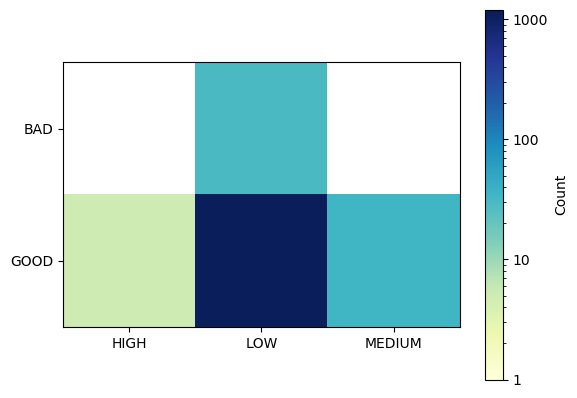

In [28]:
# Trasformiamo i dati in una matrice utilizzando il metodo pivot
matrix = family_results.pivot(index='Rating', columns='nr/nd', values='Count')
# Creiamo la heatmap utilizzando imshow
plt.imshow(matrix, cmap='YlGnBu', interpolation='nearest', norm=mcolors.LogNorm(vmin=1, vmax=1200))

# Aggiungiamo una colorbar per indicare il valore dei colori
cbar = plt.colorbar(label='Count')

# Impostiamo le etichette degli assi
plt.xticks(np.arange(len(matrix.columns)), matrix.columns)
plt.yticks(np.arange(len(matrix.index)), matrix.index)

# Modifichiamo le etichette della colorbar, ci sembra più chiaro avere 1, 10, 100, 1000 espressi così, piuttosto che come potenze di 10 (di default)
ticks = [1, 10, 100, 1000]
cbar.set_ticks(ticks)
cbar.set_ticklabels(ticks)
# Mostriamo il grafico
plt.show()